In [12]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns

base_path = '/home/maj/data/insideairbnb/processed/'
train = pd.read_csv(base_path + 'train.csv', low_memory=False)
validate = pd.read_csv(base_path + 'validate.csv', low_memory=False)
test = pd.read_csv(base_path + 'test.csv', low_memory=False)
train_validate = pd.concat([train, validate])

train_validate.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,...,house_rules_p,review_len,review_spec,review_num,svd_R,review_p,review_s,if_monthly,distance_min,price_log
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.432058,0.000776,0.997301,0.457991,0.001416,0.003226,-0.000436,0.000838,0.004530,0.546703,...,0.000111,-0.000343,-0.006913,-0.004571,0.005599,0.002076,0.001881,-0.007906,-0.003711,4.855212
std,0.495391,0.999817,0.051884,0.498261,1.001676,1.003955,1.013899,1.005067,0.982705,0.497843,...,1.000088,0.993335,0.956155,0.990426,0.992535,0.993063,0.992220,0.986144,0.999398,0.698210
min,0.000000,-0.243628,0.000000,0.000000,-1.435661,-1.621742,-0.246156,-0.634275,-12.209914,0.000000,...,-6.169202,-2.179418,-1.110441,-0.884758,-6.420100,-8.742889,-5.402021,-0.266410,-1.065591,2.302585
25%,0.000000,-0.238199,1.000000,0.000000,-0.937338,-0.481991,-0.246156,-0.590649,-0.080458,0.000000,...,-0.527809,-0.495224,-0.254877,-0.489322,-0.317731,-0.263927,-0.196427,-0.266410,-0.557558,4.369448
50%,0.000000,-0.232771,1.000000,0.000000,0.059306,-0.481991,-0.182337,-0.401604,0.242994,1.000000,...,-0.527809,0.004908,-0.142047,-0.108233,0.009905,-0.000321,0.029038,-0.266410,-0.323735,4.828314
75%,1.000000,-0.194770,1.000000,1.000000,1.055951,0.657761,-0.118518,0.150989,0.566446,1.000000,...,0.405026,0.297912,-0.011113,0.135818,0.502167,0.372443,0.394104,-0.266410,0.122526,5.298317
max,1.000000,9.636534,1.000000,1.000000,2.052595,4.077015,50.745168,11.275558,0.728172,1.000000,...,6.523932,18.193288,28.370835,19.118522,4.899802,5.618845,4.126983,3.753609,6.003178,6.906755


In [13]:
# https://www.tensorflow.org/tutorials/keras/regression
# https://stackoverflow.com/questions/55924789/normalization-of-input-data-in-keras

# need to 'pickle' model creation to allow for multiprocess parallel execution for grid search
# see https://github.com/keras-team/keras/issues/6862
def create_model(neurons):
    m = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu', input_shape=[len(train.columns)-1]),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    m.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) # also sgd, keras.optimizers.RMSprop
    return m


# test the model
m = create_model(16)
m.fit(train_validate.drop('price_log', axis=1).to_numpy(),
    train_validate.price_log.to_numpy(),
    epochs=100,
    batch_size=32,
    verbose = 1)
m.summary()

Train on 8522 samples
Epoch 1/100
8522/8522 [==============================] - 3s 402us/sample - loss: 16.1251 - mae: 3.8173 - mse: 16.1251
Epoch 2/100
8522/8522 [==============================] - 2s 274us/sample - loss: 1.9271 - mae: 1.1025 - mse: 1.9271
Epoch 3/100
8522/8522 [==============================] - 2s 275us/sample - loss: 0.4962 - mae: 0.5465 - mse: 0.4962
Epoch 4/100
8522/8522 [==============================] - 2s 273us/sample - loss: 0.4049 - mae: 0.4972 - mse: 0.4049
Epoch 5/100
8522/8522 [==============================] - 2s 276us/sample - loss: 0.3539 - mae: 0.4603 - mse: 0.3539
Epoch 6/100
8522/8522 [==============================] - 2s 279us/sample - loss: 0.3163 - mae: 0.4351 - mse: 0.3163
Epoch 7/100
8522/8522 [==============================] - 2s 268us/sample - loss: 0.2902 - mae: 0.4158 - mse: 0.2902
Epoch 8/100
8522/8522 [==============================] - 2s 274us/sample - loss: 0.2727 - mae: 0.4037 - mse: 0.2727
Epoch 9/100
8522/8522 [=========================

8522/8522 [==============================] - 2s 278us/sample - loss: 0.1712 - mae: 0.3147 - mse: 0.1712
Epoch 71/100
8522/8522 [==============================] - 2s 271us/sample - loss: 0.1706 - mae: 0.3139 - mse: 0.1706
Epoch 72/100
8522/8522 [==============================] - 2s 279us/sample - loss: 0.1714 - mae: 0.3143 - mse: 0.1714
Epoch 73/100
8522/8522 [==============================] - 2s 277us/sample - loss: 0.1684 - mae: 0.3111 - mse: 0.1684
Epoch 74/100
8522/8522 [==============================] - 2s 275us/sample - loss: 0.1689 - mae: 0.3129 - mse: 0.1689
Epoch 75/100
8522/8522 [==============================] - 2s 279us/sample - loss: 0.1719 - mae: 0.3150 - mse: 0.1719
Epoch 76/100
8522/8522 [==============================] - 2s 274us/sample - loss: 0.1700 - mae: 0.3129 - mse: 0.1700
Epoch 77/100
8522/8522 [==============================] - 2s 276us/sample - loss: 0.1721 - mae: 0.3155 - mse: 0.1721
Epoch 78/100
8522/8522 [==============================] - 2s 276us/sample - l

In [14]:
%%time
grid = GridSearchCV(estimator=KerasRegressor(build_fn=create_model, verbose=0),
                    param_grid=dict(neurons=[4, 8, 16, 32]),
                    n_jobs=1) # OOM if set 2?

grid_result = grid.fit(train_validate.drop('price_log', axis=1).to_numpy(),
                       train_validate.price_log.to_numpy(),
                       epochs=500,
                       batch_size=64)
grid_result.best_params_

{'neurons': 32}

In [15]:
grid_result.best_estimator_.model.evaluate(test.drop('price_log', axis=1).to_numpy(), test.price_log.to_numpy())

1504/1504 [==============================] - 0s 190us/sample - loss: 0.1432 - mae: 0.2887 - mse: 0.1432


[0.14320870552291262, 0.288733, 0.1432087]

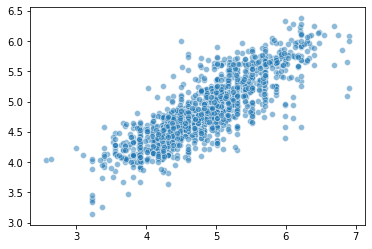

In [16]:
import seaborn as sns
sns.scatterplot(x=test.price_log.to_numpy(),
                y=grid_result.best_estimator_.model.predict(test.drop('price_log', axis=1).to_numpy()).flatten(),
                alpha=0.5)